# ModelList (Multi-Output) QEP Regression

## Introduction

This notebook demonstrates how to wrap uncorrelated QEP models into a convenient Multi-Output QEP model using a ModelList. 

Unlike in the Multitask case, this do not model correlations between outcomes, but treats outcomes independently. This is equivalent to setting up a separate QEP for each outcome, but can be much more convenient to handle, in particular it does not require manually looping over models when fitting or predicting.

This type of model is useful if 
- when the number of training / test points is different for the different outcomes
- using different covariance modules and / or likelihoods for each outcome

For block designs (i.e. when the above points do not apply), you should instead use a batch mode GP as described in the [batch uncorrelated multioutput example](./Batch_Uncorrelated_Multioutput_QEP.ipynb). This will be much faster because it uses additional parallelism.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### Set up training data

In the next cell, we set up the training data for this example. We'll be using a different number of training examples for the different QEPs.

In [2]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

## Set up the sub-models

Each individual model uses the `ExactQEP` model from the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).

In [3]:
POWER = 1.0
class ExactQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)
    

likelihood1 = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model1 = ExactQEPModel(train_x1, train_y1, likelihood1)

likelihood2 = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model2 = ExactQEPModel(train_x2, train_y2, likelihood2)

We now collect the submodels in an `UncorrelatedMultiOutputQEP`, and the respective likelihoods in a `MultiOutputLikelihood`. These are container modules that make it easy to work with multiple outputs. In particular, they will take in and return lists of inputs / outputs and delegate the data to / from the appropriate sub-model (it is important that the order of the inputs / outputs corresponds to the order of models with which the containers were instantiated).

In [4]:
model = qpytorch.models.UncorrelatedModelList(model1, model2)
likelihood = qpytorch.likelihoods.LikelihoodList(model1.likelihood, model2.likelihood)

### Set up overall Marginal Log Likelihood

Assuming independence, the MLL for the container model is simply the sum of the MLLs for the individual models. `SumMarginalLogLikelihood` is a convenient container for this (by default it uses an `ExactMarginalLogLikelihood` for each submodel)

In [5]:
from qpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

### Train the model hyperparameters

With the containers in place, the models can be trained in a single loop on the container (note that this means that optimization is performed jointly, which can be an issue if the individual submodels require training via very different step sizes).

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.597
Iter 2/50 - Loss: 1.566
Iter 3/50 - Loss: 1.530
Iter 4/50 - Loss: 1.489
Iter 5/50 - Loss: 1.441
Iter 6/50 - Loss: 1.387
Iter 7/50 - Loss: 1.326
Iter 8/50 - Loss: 1.259
Iter 9/50 - Loss: 1.190
Iter 10/50 - Loss: 1.124
Iter 11/50 - Loss: 1.064
Iter 12/50 - Loss: 1.014
Iter 13/50 - Loss: 0.973
Iter 14/50 - Loss: 0.941
Iter 15/50 - Loss: 0.915
Iter 16/50 - Loss: 0.892
Iter 17/50 - Loss: 0.873
Iter 18/50 - Loss: 0.855
Iter 19/50 - Loss: 0.839
Iter 20/50 - Loss: 0.823
Iter 21/50 - Loss: 0.807
Iter 22/50 - Loss: 0.791
Iter 23/50 - Loss: 0.774
Iter 24/50 - Loss: 0.757
Iter 25/50 - Loss: 0.737
Iter 26/50 - Loss: 0.717
Iter 27/50 - Loss: 0.696
Iter 28/50 - Loss: 0.674
Iter 29/50 - Loss: 0.651
Iter 30/50 - Loss: 0.628
Iter 31/50 - Loss: 0.605
Iter 32/50 - Loss: 0.583
Iter 33/50 - Loss: 0.562
Iter 34/50 - Loss: 0.542
Iter 35/50 - Loss: 0.523
Iter 36/50 - Loss: 0.505
Iter 37/50 - Loss: 0.488
Iter 38/50 - Loss: 0.470
Iter 39/50 - Loss: 0.452
Iter 40/50 - Loss: 0.434
Iter 41/5

### Make predictions with the model

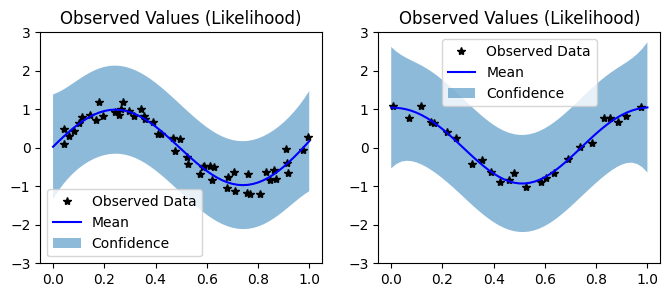

In [10]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))
    
for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region(alpha=.1)
    
    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()
    
    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None